In [1]:
from pathlib import Path
import pandas as pd
import torchaudio, torch, librosa
from collections import Counter
from tqdm import tqdm
import numpy as np
import shutil

# 입력 루트
ROOT = Path(r"D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감정분류대화음성\감정 분류를 위한 대화 음성 데이터셋")
PARTS = ["4차", "5차", "5_2차"]

# 출력 루트
OUTPUT_DIR = Path(r"D:\ex\최종프로젝트\AI_Dev_3rd_Project\CHOI\datasets\KES_processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [5]:
label_map = {
    "Sadness": "sad", "sadness": "sad", "sad": "sad",
    "Angry": "angry", "anger": "angry", "angry": "angry",
    "Disgust": "disgust", "disgust": "disgust",
    "Fear": "fear", "fear": "fear",
    "Neutral": "neutral", "neutral": "neutral",
    "Happiness": "happiness", "happiness": "happiness",
    "Surprise": "surprise", "surprise": "surprise"
}

def load_and_clean(part_name):
    part_dir = ROOT / part_name
    csv_file = list(part_dir.glob("*.csv"))[0]
    df = pd.read_csv(csv_file, encoding="cp949")
    # 컬럼명 교정
    df = df.rename(columns={"4번감정세기": "4번 감정세기"})
    # annotator 라벨 정규화
    for i in range(1, 6):
        col = f"{i}번 감정"
        if col in df.columns:
            df[col] = df[col].map(label_map)
    df["상황"] = df["상황"].map(label_map).fillna(df["상황"])
    # wav 경로 추가
    df["wav_path"] = df["wav_id"].apply(lambda x: str(part_dir / f"{x}.wav"))
    df["dataset_part"] = part_name
    return df

dfs = [load_and_clean(p) for p in PARTS]
full_df = pd.concat(dfs, ignore_index=True)

IndexError: list index out of range

In [ ]:
def vote_with_situation(row):
    labels = [row.get(f"{i}번 감정") for i in range(1, 6) if pd.notna(row.get(f"{i}번 감정"))]
    if not labels: return None
    cnt = Counter(labels)
    top = cnt.most_common()
    max_vote = top[0][1]
    candidates = [lab for lab, n in top if n == max_vote]

    if len(candidates) == 1:
        return candidates[0]

    # tie → 상황 1표 추가
    situation = row.get("상황")
    if pd.notna(situation):
        cnt[situation] += 1
        top2 = cnt.most_common()
        max2 = top2[0][1]
        cands2 = [lab for lab, n in top2 if n == max2]
        if len(cands2) == 1:
            return cands2[0]

    return None  # 여전히 동률이면 drop

full_df["emotion"] = full_df.apply(vote_with_situation, axis=1)
clean_df = full_df.dropna(subset=["emotion"]).copy()


In [3]:
import pyloudnorm as pyln

target_sr = 16000
meter = pyln.Meter(target_sr)  # LUFS meter

def preprocess_audio(path, out_dir, top_db=45):
    try:
        # 1) load
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:
            y = torch.mean(y, dim=0, keepdim=True)
        if sr != target_sr:
            y = torchaudio.functional.resample(y, sr, target_sr)
        y = y.squeeze().numpy()

        # 2) loudness normalize (LUFS)
        loudness = meter.integrated_loudness(y)
        y = pyln.normalize.loudness(y, loudness, -23.0)  # target = -23 LUFS

        # 3) peak normalize [-1,1]
        peak = np.max(np.abs(y))
        if peak > 0:
            y = y / peak

        # 4) RMS normalize (optional: match to -20 dBFS RMS)
        rms = np.sqrt(np.mean(y**2))
        target_rms = 10**(-20/20)
        if rms > 0:
            y = y * (target_rms / rms)

        # 5) 앞뒤 무음만 trim
        intervals = librosa.effects.split(y, top_db=top_db)
        if len(intervals) > 0:
            start, end = intervals[0][0], intervals[-1][1]
            y = y[start:end]

        # 저장
        dest = out_dir / (Path(path).stem + "_proc.wav")
        torchaudio.save(str(dest), torch.tensor(y).unsqueeze(0), target_sr)
        return dest, len(y)/target_sr

    except Exception as e:
        print(f"[에러] {path}: {e}")
        return None, None


# === 샘플 선택 로직 ===
clean_df["trim_ratio"] = clean_df["trim_duration"] / clean_df["raw_duration"]

# 20초 이상 샘플
long_samples = clean_df[clean_df["trim_duration"] > 20]

# 많이 잘린 것, 거의 안 잘린 것
most_trimmed_long = long_samples.sort_values("trim_ratio").head(10)
least_trimmed_long = long_samples.sort_values("trim_ratio", ascending=False).head(10)

# 전체에서 많이 잘린 것
most_trimmed_all = clean_df.sort_values("trim_ratio").head(10)

# === 전처리 및 저장 ===
OUT_DIR = OUTPUT_DIR / "preproc_audition"
OUT_DIR.mkdir(exist_ok=True)

for name, subset in {
    "most_trimmed_long": most_trimmed_long,
    "least_trimmed_long": least_trimmed_long,
    "most_trimmed_all": most_trimmed_all
}.items():
    print(f"\n=== {name} ===")
    for _, row in subset.iterrows():
        out_path, dur = preprocess_audio(row["wav_path"], OUT_DIR)
        if out_path:
            print(row["wav_path"], "->", out_path, "ratio:", row["trim_ratio"])


NameError: name 'clean_df' is not defined

In [26]:
# 전처리 파이프라인 추가 부분
import soundfile as sf
import pyloudnorm as pyln

target_sr = 16000

# 1) Loudness Normalize (LUFS 기준)
def loudness_normalize(path, target_lufs=-23.0, out_dir="normalized_wav"):
    y, sr = sf.read(path)
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(y)
    y_norm = pyln.normalize.loudness(y, loudness, target_lufs)

    out_dir = Path(out_dir); out_dir.mkdir(exist_ok=True)
    out_path = out_dir / f"{Path(path).stem}_norm.wav"
    sf.write(out_path, y_norm, sr)
    return str(out_path), loudness

# clean_df["norm_path"], clean_df["orig_loudness"] = zip(*clean_df["wav_path"].map(loudness_normalize))

In [27]:
# 2) Peak + RMS Normalize (보조, clipping 방지 & 평균 에너지 안정화)
def peak_normalize(y):
    return y / (np.max(np.abs(y)) + 1e-8)

def rms_normalize(y, target_rms=0.05):
    rms = np.sqrt(np.mean(y**2))
    return y * (target_rms / (rms + 1e-8))

In [28]:
# 3) Head-tail VAD (top_db=45)
def head_tail_trim(y, sr, top_db=45):
    intervals = librosa.effects.split(y, top_db=top_db)
    if len(intervals) == 0:
        return y
    start, end = intervals[0][0], intervals[-1][1]
    return y[start:end]

In [40]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_wav(path, target_lufs=-23.0, top_db=45):
    try:
        # 1) wav load (torchaudio → numpy)
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:      # 스테레오 → 모노
            y = torch.mean(y, dim=0, keepdim=True)
        y = y.squeeze(0).numpy()

        raw_len = len(y) / sr

        # 3) Loudness normalize (메모리 array 기준)
        meter = pyln.Meter(sr)
        loudness = meter.integrated_loudness(y)
        y = pyln.normalize.loudness(y, loudness, target_lufs)

        # 2) Head-tail VAD
        y_trim = head_tail_trim(y, sr, top_db=top_db)

        # 4) Peak + RMS normalize (보조 안정화)
        y_trim = peak_normalize(y_trim)
        y_trim = rms_normalize(y_trim)

        trim_len = len(y_trim) / sr
        ratio = trim_len / raw_len if raw_len > 0 else 0.0
        tail_sil = raw_len - trim_len

        return raw_len, trim_len, ratio, tail_sil, loudness

    except Exception as e:
        print(f"[ERROR] {path} - {e}")
        return None, None, None, None, None

In [43]:
num_workers = 5
results = []
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    for r in tqdm(executor.map(process_wav, clean_df["wav_path"]),
                  total=len(clean_df), desc="Preprocessing"):
        results.append(r)

clean_df[["raw_duration","trim_duration","speech_ratio","tail_silence_sec","orig_loudness"]] = \
    pd.DataFrame(results, index=clean_df.index)


Preprocessing:   0%|          | 0/42408 [00:00<?, ?it/s]d:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
d:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
d:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
d:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
d:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped sampl

In [41]:
test=process_wav(Path(r'D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감정분류대화음성\감정 분류를 위한 대화 음성 데이터셋\4차\5e2ac3d55807b852d9e01fd6.wav'))

In [45]:
clean_df

,wav_id,발화문,상황,1번 감정,1번 감정세기,2번 감정,2번 감정세기,3번 감정,3번 감정세기,4번 감정,...,wav_path,exists,dataset_part,emotion,raw_duration,trim_duration,speech_ratio,tail_silence_sec,orig_loudness,trim_ratio
0,5e258fd1305bcf3ad153a6a4,"어, 청소 니가 대신 해 줘!",angry,neutral,0,angry,1,neutral,0,neutral,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,4차,neutral,3.285333,3.242667,0.987013,0.042667,-41.292202,0.987013
1,5e258fe2305bcf3ad153a6a5,둘 다 청소 하기 싫어. 귀찮아.,angry,neutral,0,angry,1,neutral,0,neutral,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,4차,neutral,3.200000,3.114667,0.973333,0.085333,-40.749878,0.973333
2,5e258ff5305bcf3ad153a6a6,둘 다 하기 싫어서 화내.,angry,angry,1,angry,1,neutral,0,angry,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,4차,angry,3.413333,3.328000,0.975000,0.085333,-39.552742,0.975000
3,5e25902f305bcf3ad153a6a9,그럼 방세는 어떡해.,angry,sad,1,sad,1,sad,1,sad,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,4차,sad,3.200000,3.114667,0.973333,0.085333,-39.161458,0.973333
4,5e27f90b5807b852d9e0157b,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,sad,sad,1,sad,1,sad,1,sad,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,4차,sad,10.880000,10.784000,0.991176,0.096000,-26.119710,0.991176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43970,5fbe313c44697678c497c05a,나 엘리베이터에 갇혔어.,fear,happiness,1,sad,1,sad,2,sad,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,5_2차,sad,2.901333,2.805333,0.966912,0.096000,-50.736072,0.966912
43971,5fbe251044697678c497bfb8,하지만 기분이 나쁜 걸 어떡해?,angry,sad,1,fear,1,sad,2,sad,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,5_2차,sad,3.882667,3.786667,0.975275,0.096000,-53.694896,0.975275
43972,5fbe31584c55eb78bd7cee7f,자취방 엘리베이턴데 정전인가봐.,fear,sad,1,neutral,0,sad,2,fear,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,5_2차,sad,3.669333,3.584000,0.976744,0.085333,-47.236171,0.976744
43973,5fbe2f8544697678c497c047,나 드디어 프로젝트 끝났어!,happiness,disgust,1,sad,1,neutral,0,happiness,...,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,5_2차,sad,3.072000,2.954667,0.961806,0.117333,-48.895218,0.961806


In [48]:
# =========================
# 4) EDA 체크포인트
# =========================
clean_df["trim_ratio"] = clean_df["trim_duration"] / clean_df["raw_duration"]

most_trimmed = clean_df.sort_values("trim_ratio").head(10)
long_samples = clean_df[clean_df["trim_duration"] > 20]

print("=== 많이 잘린 샘플 (ratio 낮음, 상위 10개) ===")
print(most_trimmed[["wav_id","emotion","raw_duration","trim_duration","trim_ratio"]])

print("\n=== 20초 이상 긴 샘플 ===")
print(long_samples[["wav_id","emotion","raw_duration","trim_duration","trim_ratio"]])


# =========================
# 20초 이상 샘플만 대상으로 2차 VAD 수행 & 저장
# =========================
# def run_two_stage_vad(path, top_db_stage1=45, top_db_stage2=30):
#     # load
#     y, sr = torchaudio.load(path)
#     if y.shape[0] > 1:
#         y = torch.mean(y, dim=0, keepdim=True)
#     y = y.squeeze(0).numpy()

#     raw_len = len(y)/sr

#     # 1차 VAD (45)
#     y_trim = head_tail_trim(y, sr, top_db=top_db_stage1)

#     # 2차 VAD (30)
#     y_trim2 = head_tail_trim(y_trim, sr, top_db=top_db_stage2)

#     trim_len = len(y_trim2)/sr
#     ratio = trim_len/raw_len if raw_len > 0 else 0.0

#     return raw_len, trim_len, ratio, sr, y_trim2


# 20초 이상인 샘플 대상으로 실행
long_samples = clean_df[clean_df["trim_duration"] > 20].copy()
results = []
for _, row in long_samples.iterrows():
    raw, trim, ratio, sr, y_trim = process_wav(row["wav_path"])
    results.append({
        "wav_id": row["wav_id"],
        "emotion": row["emotion"],
        "src": row["wav_path"],
        "raw": raw,
        "trim": trim,
        "ratio": ratio,
        "y_trim": y_trim,
        "sr": sr
    })
df_results = pd.DataFrame(results)

# ratio 기준 정렬
df_sorted = df_results.sort_values("ratio")

# 많이 잘린 5개 / 거의 안 잘린 5개
most_trimmed2 = df_sorted.head(5).sort_values("wav_id", ascending=True)
least_trimmed2 = df_sorted.tail(5).sort_values("wav_id", ascending=True)

# =========================
# 많이 잘린 / 긴 샘플 저장 (전처리 버전)
# =========================
out_dir_most = Path("eda_samples_most"); out_dir_most.mkdir(exist_ok=True)
out_dir_long = Path("eda_samples_long"); out_dir_long.mkdir(exist_ok=True)

# 많이 잘린 상위 5개
for _, row in most_trimmed.head(5).sort_values("wav_id").iterrows():
    raw, trim, ratio, tail_sil, loudness, y_trim, sr = process_wav(row["wav_path"])
    if y_trim is not None:
        out_path = out_dir_most / f"{row['wav_id']}_eda.wav"
        torchaudio.save(str(out_path), torch.tensor(y_trim).unsqueeze(0), sr)
        print(f"[MOST] 저장: {out_path} (raw={raw:.2f}s, trim={trim:.2f}s, ratio={ratio:.2f})")

# 긴 샘플 상위 5개
for _, row in long_samples.head(5).sort_values("wav_id").iterrows():
    raw, trim, ratio, tail_sil, loudness, y_trim, sr = process_wav(row["wav_path"])
    if y_trim is not None:
        out_path = out_dir_long / f"{row['wav_id']}_eda.wav"
        torchaudio.save(str(out_path), torch.tensor(y_trim).unsqueeze(0), sr)
        print(f"[LONG] 저장: {out_path} (raw={raw:.2f}s, trim={trim:.2f}s, ratio={ratio:.2f})")


=== 많이 잘린 샘플 (ratio 낮음, 상위 10개) ===
                         wav_id    emotion  raw_duration  trim_duration  \
43618  5fbdecee576e9378b67ad2eb        sad      6.272000       1.258667   
43644  5fbdeeae44697678c497be94    neutral      4.010667       0.853333   
42780  5fbc9e2d576e9378b67acf13    neutral      6.997333       1.514667   
36920  5fba1667576e9378b67ac752    neutral      4.906667       1.120000   
43827  5fbe24ae576e9378b67ad3e1    neutral      4.906667       1.216000   
32023  5f85c4fd111dfd48d40fdfbf  happiness      3.328000       0.842667   
42537  5fbca227576e9378b67acf4b        sad      6.016000       1.525333   
43065  5fbd0d2e4c55eb78bd7ceaed    disgust     11.136000       3.008000   
39727  5fb9c1414c55eb78bd7cdf7b    neutral      4.821333       1.333333   
41012  5fbb163e576e9378b67ac920    neutral      5.504000       1.525333   

       trim_ratio  
43618    0.200680  
43644    0.212766  
42780    0.216463  
36920    0.228261  
43827    0.247826  
32023    0.253205 

ValueError: not enough values to unpack (expected 7, got 5)

In [47]:
# EDA 체크포인트
clean_df["trim_ratio"] = clean_df["trim_duration"] / clean_df["raw_duration"]

most_trimmed = clean_df.sort_values("trim_ratio").head(10)
long_samples = clean_df[clean_df["trim_duration"] > 20]

print("=== 많이 잘린 샘플 ===")
print(most_trimmed[["wav_id","emotion","raw_duration","trim_duration","trim_ratio"]])

print("\n=== 20초 이상 긴 샘플 ===")
print(long_samples[["wav_id","emotion","raw_duration","trim_duration","trim_ratio"]])

# 샘플 저장: ratio 낮은 5개 / 높은 5개
df_sorted = long_samples.sort_values("trim_ratio")
most_trimmed2 = df_sorted.head(5).sort_values("wav_id")
least_trimmed2 = df_sorted.tail(5).sort_values("wav_id")

out_dir_most = Path("vad_stage2_most"); out_dir_most.mkdir(exist_ok=True)
out_dir_least = Path("vad_stage2_least"); out_dir_least.mkdir(exist_ok=True)

for _, row in most_trimmed2.iterrows():
    y, sr = torchaudio.load(row["wav_path"])
    out_path = out_dir_most / f"{Path(row['wav_path']).stem}_trim2.wav"
    torchaudio.save(str(out_path), y, sr)
    print(f"[MOST] 원본={row['wav_path']} → 저장={out_path}")

for _, row in least_trimmed2.iterrows():
    y, sr = torchaudio.load(row["wav_path"])
    out_path = out_dir_least / f"{Path(row['wav_path']).stem}_trim2.wav"
    torchaudio.save(str(out_path), y, sr)
    print(f"[LEAST] 원본={row['wav_path']} → 저장={out_path}")

=== 많이 잘린 샘플 ===
                         wav_id    emotion  raw_duration  trim_duration  \
43618  5fbdecee576e9378b67ad2eb        sad      6.272000       1.258667   
43644  5fbdeeae44697678c497be94    neutral      4.010667       0.853333   
42780  5fbc9e2d576e9378b67acf13    neutral      6.997333       1.514667   
36920  5fba1667576e9378b67ac752    neutral      4.906667       1.120000   
43827  5fbe24ae576e9378b67ad3e1    neutral      4.906667       1.216000   
32023  5f85c4fd111dfd48d40fdfbf  happiness      3.328000       0.842667   
42537  5fbca227576e9378b67acf4b        sad      6.016000       1.525333   
43065  5fbd0d2e4c55eb78bd7ceaed    disgust     11.136000       3.008000   
39727  5fb9c1414c55eb78bd7cdf7b    neutral      4.821333       1.333333   
41012  5fbb163e576e9378b67ac920    neutral      5.504000       1.525333   

       trim_ratio  
43618    0.200680  
43644    0.212766  
42780    0.216463  
36920    0.228261  
43827    0.247826  
32023    0.253205  
42537    0.253546

LibsndfileError: Error opening 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\4차\\5e34c2875807b852d9e067a8.wav': System error.

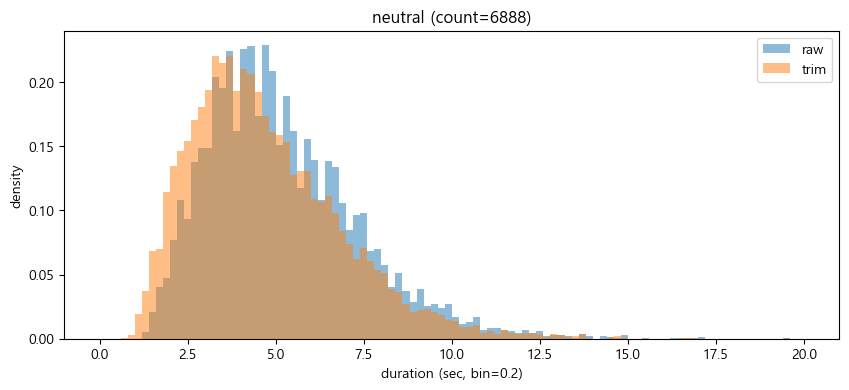

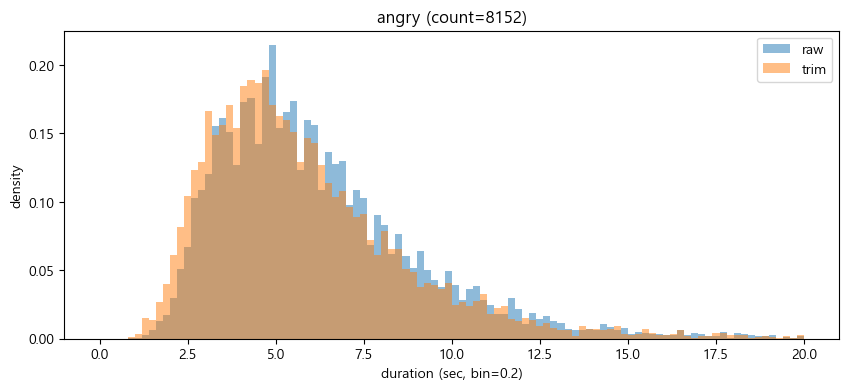

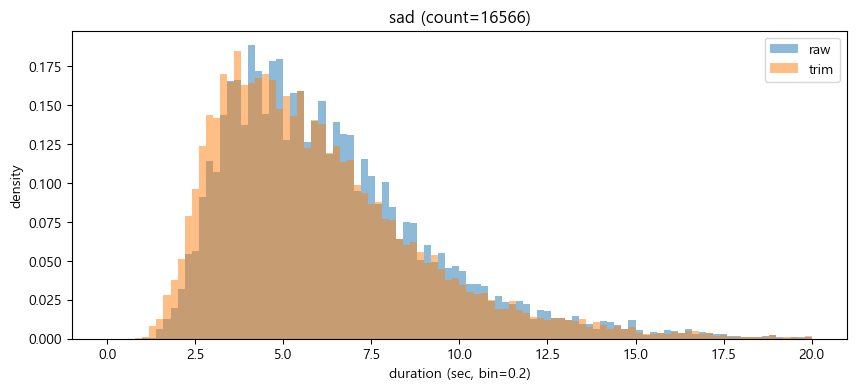

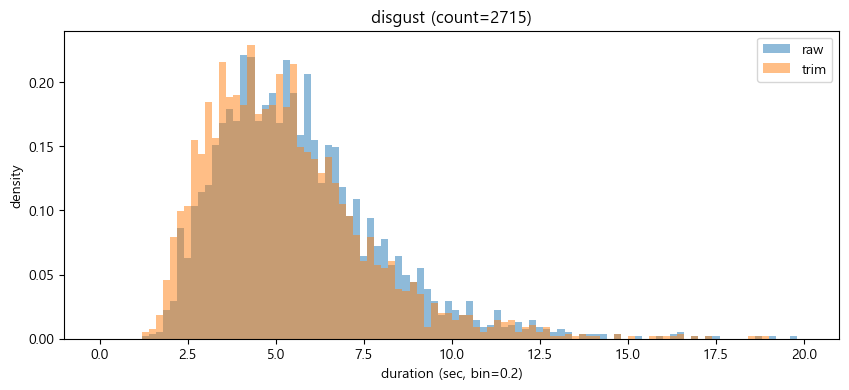

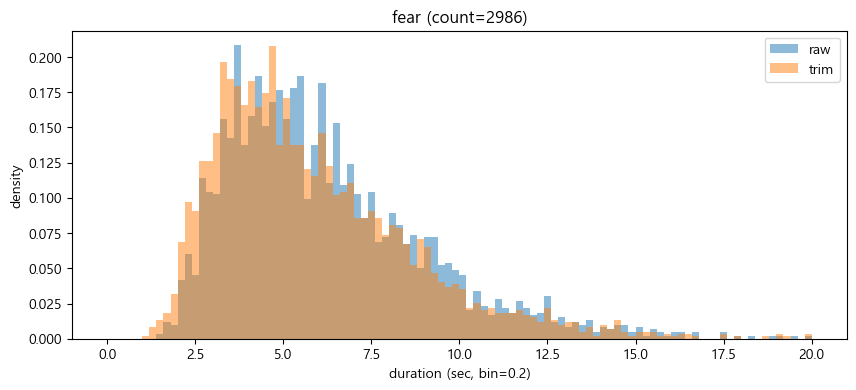

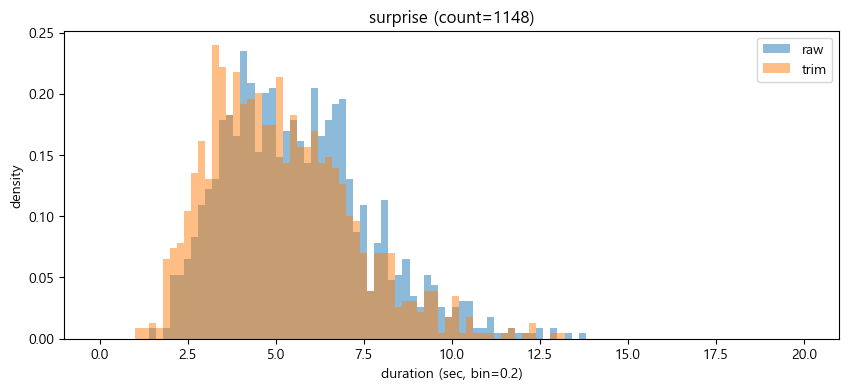

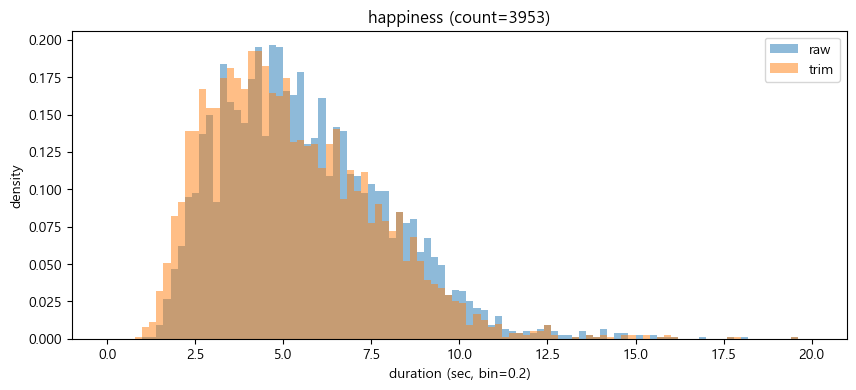

In [35]:
import numpy as np
import matplotlib.pyplot as plt

BIN = 0.2
MAX_SEC = 20.0
bins = np.arange(0, MAX_SEC+BIN, BIN)

# 감정별 히스토그램 (raw vs trim 비교)
emotions = clean_df['emotion'].unique()

for emo in emotions:
    subset = clean_df[clean_df['emotion'] == emo]
    raw = subset['raw_duration'].dropna()
    trim = subset['trim_duration'].dropna()

    plt.figure(figsize=(10,4))
    plt.hist(raw, bins=bins, alpha=0.5, label='raw', density=True)
    plt.hist(trim, bins=bins, alpha=0.5, label='trim', density=True)
    plt.title(f"{emo} (count={len(subset)})")
    plt.xlabel("duration (sec, bin=0.2)")
    plt.ylabel("density")
    plt.legend()
    plt.show()


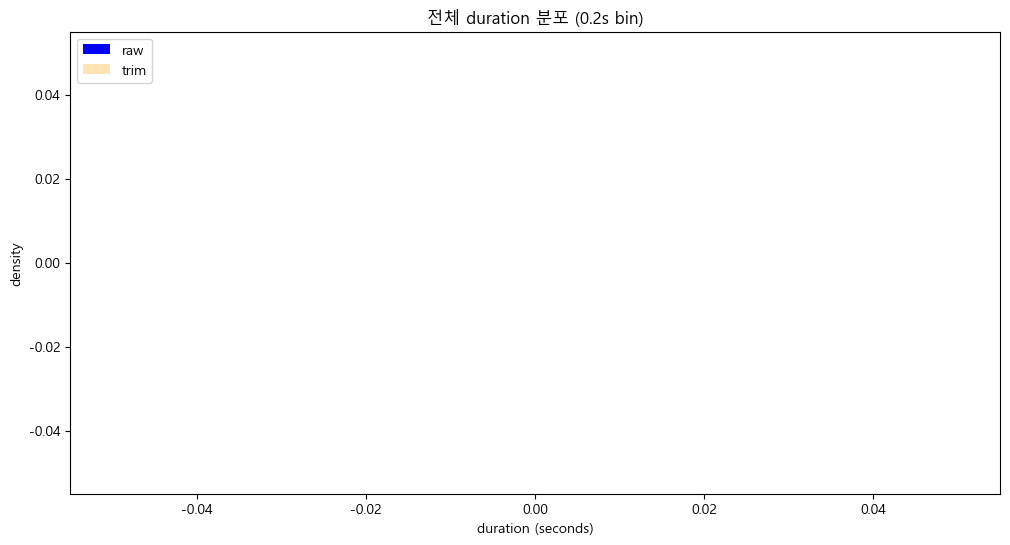

In [9]:
import matplotlib.pyplot as plt
import numpy as np

BIN = 0.2
MAX_SEC = 20.0
bins_02 = np.arange(0, MAX_SEC+BIN, BIN)

raw = clean_df['raw_duration'].dropna()
trim = clean_df['trim_duration'].dropna()

plt.figure(figsize=(12,6))
plt.hist(raw, bins=bins_02, alpha=1, label='raw', density=True, color='blue')
plt.hist(trim, bins=bins_02, alpha=0.3, label='trim', density=True, color='orange')
plt.title("전체 duration 분포 (0.2s bin)")
plt.xlabel("duration (seconds)")
plt.ylabel("density")
plt.legend()
plt.show()


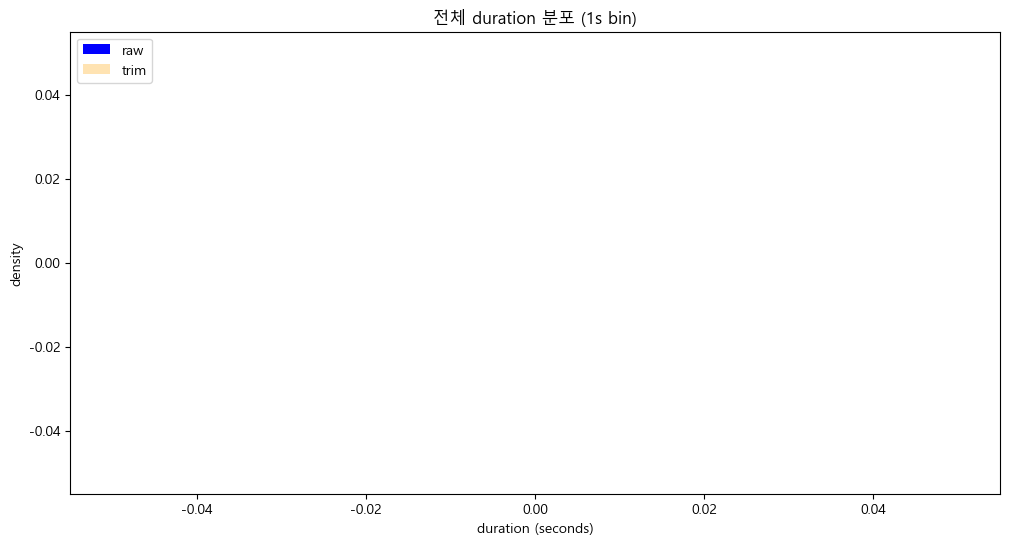

In [10]:
BIN = 1.0
MAX_SEC = 30.0  # 필요시 늘려도 됨
bins_1 = np.arange(0, MAX_SEC+BIN, BIN)

plt.figure(figsize=(12,6))
plt.hist(raw, bins=bins_1, alpha=1, label='raw', density=True, color='blue')
plt.hist(trim, bins=bins_1, alpha=0.3, label='trim', density=True, color='orange')
plt.title("전체 duration 분포 (1s bin)")
plt.xlabel("duration (seconds)")
plt.ylabel("density")
plt.legend()
plt.show()


In [11]:
def ensure_agreement_ratio(df):
    ann_cols = [f"{i}번 감정" for i in range(1, 6)]
    def _agg(row):
        votes = [row.get(c) for c in ann_cols if pd.notna(row.get(c))]
        if not votes: return pd.Series({"agreement_ratio": 0})
        cnt = Counter(votes)
        top = cnt.most_common(1)[0][1]
        return pd.Series({"agreement_ratio": top/len(votes)})
    out = df.apply(_agg, axis=1)
    df["agreement_ratio"] = out["agreement_ratio"]
    return df

clean_df = ensure_agreement_ratio(clean_df)

# 오디오 품질 계산
def compute_quality(path, target_sr=16000):
    try:
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:
            y = torch.mean(y, dim=0, keepdim=True)
        if sr != target_sr:
            y = torchaudio.functional.resample(y, sr, target_sr)
        y = y.squeeze().numpy()
        dur = len(y)/target_sr
        rms = np.sqrt(np.mean(y**2))+1e-8
        peak = np.max(np.abs(y))
        crest = peak/rms
        clip_ratio = np.mean(np.abs(y) >= 0.99)
        noise_floor = np.percentile(np.abs(y), 10)
        snr_proxy = 20*np.log10(rms/(noise_floor+1e-8))
        return dur, crest, clip_ratio, snr_proxy
    except:
        return None, None, None, None

q_metrics = []
for p in tqdm(clean_df["wav_path"], desc="quality"):
    d,c,cl,s = compute_quality(p)
    q_metrics.append((d,c,cl,s))
clean_df[["duration","crest","clipping_ratio","snr_proxy_db"]] = pd.DataFrame(q_metrics)

filtered_df = clean_df[
    (clean_df["agreement_ratio"]>=0.6) &
    (clean_df["duration"]>=0.2) &
    (clean_df["snr_proxy_db"]>=10) &
    (clean_df["crest"]<=30) &
    (clean_df["clipping_ratio"]<=0.01)
].copy()


quality: 100%|██████████| 42408/42408 [06:21<00:00, 111.10it/s]


데이터 크기: 35434

컬럼 목록: ['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정', '3번 감정세기', '4번 감정', '4번 감정세기', '5번 감정', '5번 감정세기', '나이', '성별', 'wav_path', 'exists', 'dataset_part', 'emotion', 'raw_duration', 'trim_duration', 'speech_ratio', 'tail_silence_sec', 'orig_loudness', 'trim_ratio', 'agreement_ratio', 'duration', 'crest', 'clipping_ratio', 'snr_proxy_db']

샘플 5행:
                     wav_id                        발화문     상황    1번 감정  \
0  5e258fd1305bcf3ad153a6a4           어, 청소 니가 대신 해 줘!  angry  neutral   
1  5e258fe2305bcf3ad153a6a5         둘 다 청소 하기 싫어. 귀찮아.  angry  neutral   
2  5e258ff5305bcf3ad153a6a6             둘 다 하기 싫어서 화내.  angry    angry   
3  5e25902f305bcf3ad153a6a9                그럼 방세는 어떡해.  angry      sad   
4  5e27f90b5807b852d9e0157b  권태긴줄 알았는데 다른 사람이 생겼나보더라고.    sad      sad   

   1번 감정세기  2번 감정  2번 감정세기    3번 감정  3번 감정세기    4번 감정  ...  trim_duration  \
0        0  angry        1  neutral        0  neutral  ...           None   
1        0  

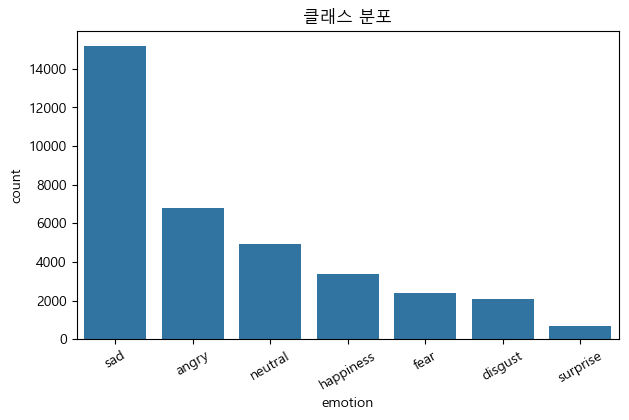


=== 감정별 평균 품질 메트릭 ===
           duration  snr_proxy_db     crest  clipping_ratio  agreement_ratio
emotion                                                                     
angry      6.230913     42.730829  8.861448    2.903595e-07         0.810929
disgust    5.910441     42.761426  8.891729    5.646240e-07         0.810480
fear       6.128980     42.456663  8.619248    2.632788e-07         0.791146
happiness  5.808141     42.917490  8.753852    4.308283e-07         0.823659
neutral    5.509598     45.590028  9.522281    1.740286e-06         0.700344
sad        6.258279     42.813019  8.736243    2.277985e-07         0.859015
surprise   5.649274     43.053127  8.763359    5.409038e-07         0.691594


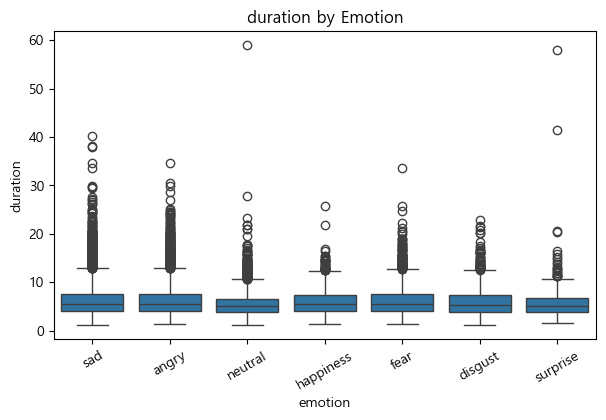

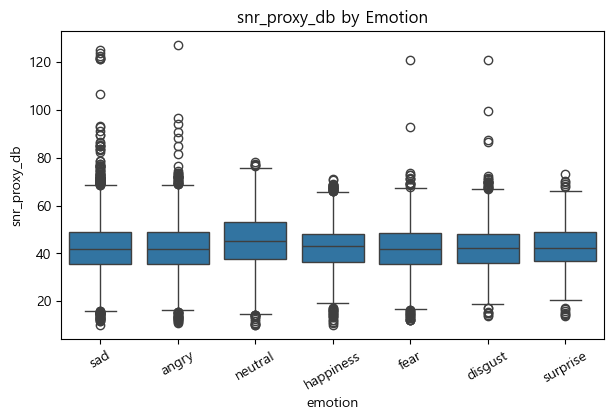

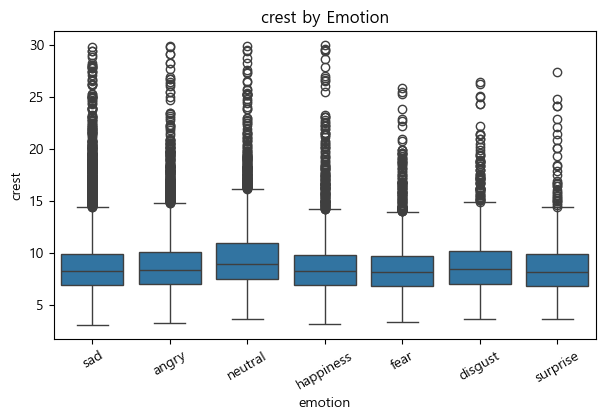

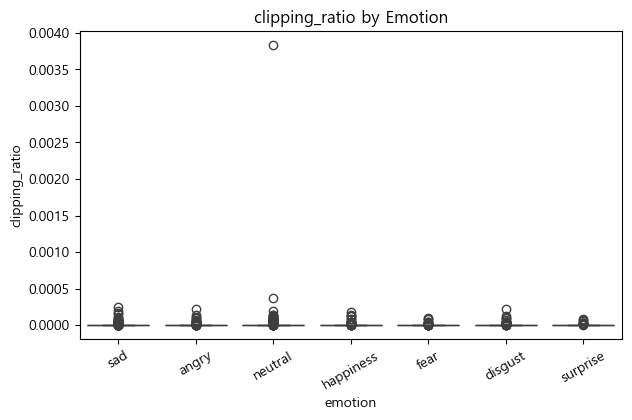

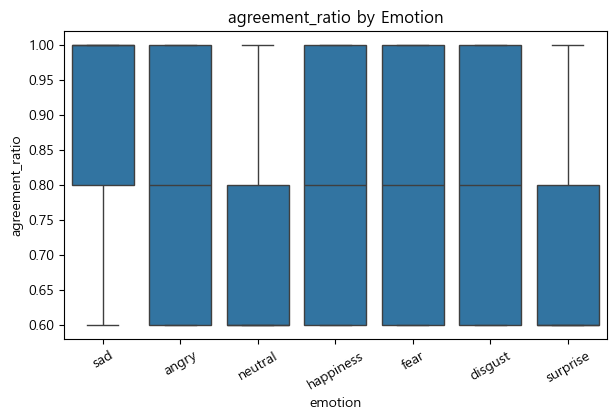

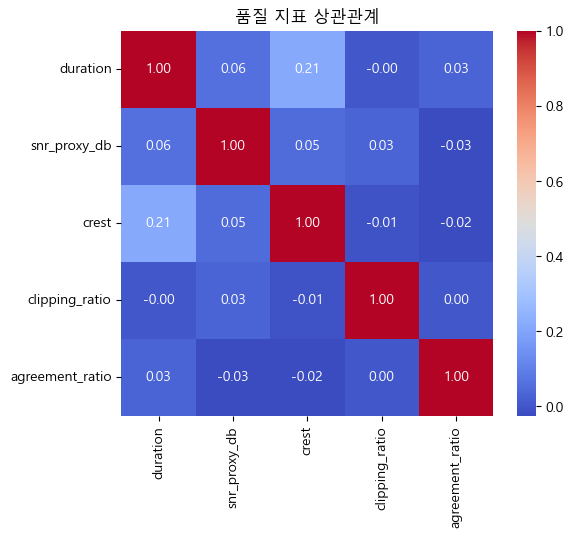

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1. 기본 정보
# ------------------------------
print("데이터 크기:", len(filtered_df))
print("\n컬럼 목록:", filtered_df.columns.tolist())
print("\n샘플 5행:")
print(filtered_df.head())

# ------------------------------
# 2. 수치형 기술 통계
# ------------------------------
num_cols = ["duration", "snr_proxy_db", "crest", "clipping_ratio", "agreement_ratio"]
print("\n=== 기술 통계 요약 ===")
print(filtered_df[num_cols].describe())

# ------------------------------
# 3. 클래스 분포
# ------------------------------
print("\n=== 클래스 분포 ===")
print(filtered_df["emotion"].value_counts())

# 시각화
plt.figure(figsize=(7,4))
sns.countplot(x="emotion", data=filtered_df, order=filtered_df["emotion"].value_counts().index)
plt.title("클래스 분포")
plt.xticks(rotation=30)
plt.show()

# ------------------------------
# 4. 감정별 평균 품질 메트릭
# ------------------------------
print("\n=== 감정별 평균 품질 메트릭 ===")
print(filtered_df.groupby("emotion")[num_cols].mean())

# boxplot으로 감정별 품질 분포 비교
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="emotion", y=col, data=filtered_df, order=filtered_df["emotion"].value_counts().index)
    plt.title(f"{col} by Emotion")
    plt.xticks(rotation=30)
    plt.show()

# ------------------------------
# 5. 상관관계 매트릭스
# ------------------------------
corr = filtered_df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("품질 지표 상관관계")
plt.show()


In [13]:
target_sr = 16000

def process_and_save(row, out_dir=OUTPUT_DIR):
    src = Path(row["wav_path"])
    if not src.exists(): return None
    wav_id = row["wav_id"]

    y, sr = torchaudio.load(src)
    if y.shape[0] > 1:
        y = torch.mean(y, dim=0, keepdim=True)
    if sr != target_sr:
        y = torchaudio.functional.resample(y, sr, target_sr)
    y = y.squeeze().numpy()
    y = y/np.max(np.abs(y)+1e-8)

    L = len(y)/target_sr
    nseg = int(L//8)
    segments = []
    # 정수 세그먼트
    for i in range(nseg):
        seg = y[i*8*target_sr:(i+1)*8*target_sr]
        dest = out_dir / f"{wav_id}__seg_{i:03d}.wav"
        torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
        segments.append(dest.name)

    # 잔여 처리
    r = L % 8
    remainder = y[nseg*8*target_sr:]

    if L < 8:
        # 🔥 8초 미만 발화도 무조건 pad해서 1개 세그먼트 생성
        seg = np.pad(y, (0, int(8*target_sr - len(y))))
        dest = out_dir / f"{wav_id}__seg_000.wav"
        torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
        segments.append(dest.name)

    elif r > 0:
        if r >= 4:
            seg = np.pad(remainder, (0, int(8*target_sr - len(remainder))))
            dest = out_dir / f"{wav_id}__seg_{nseg:03d}.wav"
            torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
            segments.append(dest.name)
        # r < 4는 버림 (긴 발화 잔여)
    return segments

records = []
for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="segmenting"):
    segs = process_and_save(row)
    if segs:
        for s in segs:
            records.append({"path": s, "emotion": row["emotion"]})

meta_df = pd.DataFrame(records)
meta_df.to_csv(OUTPUT_DIR/"metadata.csv", index=False, encoding="utf-8-sig")


segmenting: 100%|██████████| 35434/35434 [08:39<00:00, 68.22it/s]


In [ ]:
# fail_count = 0
# records = []
# for idx, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="segmenting"):
#     segs = process_and_save(row)
#     if segs is None:
#         fail_count += 1
#     else:
#         for s in segs:
#             records.append({"path": s, "emotion": row["emotion"]})

# print("실패한 파일 수:", fail_count)
# print("세그먼트 총 개수:", len(records))


segmenting:  14%|█▍        | 4996/35436 [00:57<05:48, 87.39it/s] 


KeyboardInterrupt: 